# Predizione di vittoria nelle battaglie di Pokémon

*Obiettivo:* Costruire e confrontare diversi modelli per predire il vincitore di un duello Pokémon.

### Partecipanti:
- Daniele Merighi
- Luca Palazzini
- Lore

---

## Table of Contents
1. [Parametri e Configurazione](#parametri-e-configurazione)
2. [Import delle Librerie](#import-delle-librerie)
3. [Caricamento e Unione dei Dati](#caricamento-e-unione-dei-dati)
4. [Esplorazione dei Dati](#esplorazione-dei-dati)
5. [Feature Engineering](#feature-engineering)
6. [Analisi delle Correlazioni](#analisi-delle-correlazioni)
7. [Addestramento e Tuning dei Modelli](#addestramento-e-tuning-dei-modelli)
8. [Valutazione dei Modelli](#valutazione-dei-modelli)

# Parametri e Configurazione <a id="parametri-e-configurazione"></a>

In [153]:
# Definizione dei percorsi e dei parametri globali
DATASET_BASE_PATH: str = './datasets'
COMBATS_PATH: str = f"{DATASET_BASE_PATH}/combats.csv"
TYPE_CHART_PATH: str = f"{DATASET_BASE_PATH}/type_chart.csv"
POKEMON_PATH: str = f"{DATASET_BASE_PATH}/pokemon.csv"
MODEL_DIR: str = './models'
RANDOM_STATE: int = 42

# Import delle Librerie <a id="import-delle-librerie"></a>

In [154]:
# Librerie base
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sb
import pandas as pd
from typing import Tuple

# Compatibilitá con Jupyter Notebook
%matplotlib inline

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# XGBoost
from xgboost import XGBClassifier

# Salvataggio dei modelli
import joblib
import os

# Caricamento e Unione dei Dati <a id="caricamento-e-unione-dei-dati"></a>

In [155]:
# Caricamento dei DataFrame
df_combats: pd.DataFrame = pd.read_csv(COMBATS_PATH)
df_type_chart: pd.DataFrame = pd.read_csv(TYPE_CHART_PATH).fillna('None')
df_pokemon: pd.DataFrame = pd.read_csv(POKEMON_PATH).set_index('#').fillna('None')
# Prerprocessing del campo winner per avere 0 se vince il primo Pokemon e 1 se vince il_So
df_combats['Winner'] = np.where(df_combats['Winner'] == df_combats['First_pokemon'], 0, 1)
# Unione dei DataFrame dei combattimenti con quello dei Pokemon
df_combats = (df_combats
   .join(df_pokemon, on="First_pokemon", rsuffix='_F')
   .join(df_pokemon, on="Second_pokemon", rsuffix='_S')
   .drop(columns=['First_pokemon', 'Second_pokemon'])
)

## Esplorazione dei Dati <a id="esplorazione-dei-dati"></a>

In [156]:
# Stampa delle informazioni del dataset
df_combats.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Winner        50000 non-null  int64 
 1   Name          50000 non-null  object
 2   Type 1        50000 non-null  object
 3   Type 2        50000 non-null  object
 4   HP            50000 non-null  int64 
 5   Attack        50000 non-null  int64 
 6   Defense       50000 non-null  int64 
 7   Sp. Atk       50000 non-null  int64 
 8   Sp. Def       50000 non-null  int64 
 9   Speed         50000 non-null  int64 
 10  Generation    50000 non-null  int64 
 11  Legendary     50000 non-null  bool  
 12  Name_S        50000 non-null  object
 13  Type 1_S      50000 non-null  object
 14  Type 2_S      50000 non-null  object
 15  HP_S          50000 non-null  int64 
 16  Attack_S      50000 non-null  int64 
 17  Defense_S     50000 non-null  int64 
 18  Sp. Atk_S     50000 non-null  int64 
 19  Sp. 

In [157]:
df_combats.describe()

,Winner,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,HP_S,Attack_S,Defense_S,Sp. Atk_S,Sp. Def_S,Speed_S,Generation_S
count,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,0.527980,69.06692,79.121040,74.248540,72.893900,72.077020,68.214420,3.321880,69.099940,79.035100,74.148600,72.664220,72.018440,68.279220,3.34132
std,0.499221,25.27720,32.690876,31.635322,32.745608,27.916398,29.288297,1.652261,25.170108,32.413583,31.578308,32.644598,27.836053,29.108555,1.65435
min,0.000000,1.00000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,0.000000,50.00000,55.000000,50.000000,50.000000,50.000000,45.000000,2.000000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,2.00000
50%,1.000000,65.00000,75.000000,70.000000,65.000000,70.000000,65.000000,3.000000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,1.000000,80.00000,100.000000,90.000000,95.000000,90.000000,90.000000,5.000000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,1.000000,255.00000,190.000000,230.000000,194.000000,230.000000,180.000000,6.000000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [158]:
# Creiamo un bel color palette perché si
cmap: LinearSegmentedColormap = sb.diverging_palette(300, 60, s=50, l=40, as_cmap=True)
bar_color: Tuple[float, float, float, float] = cmap(0.0)

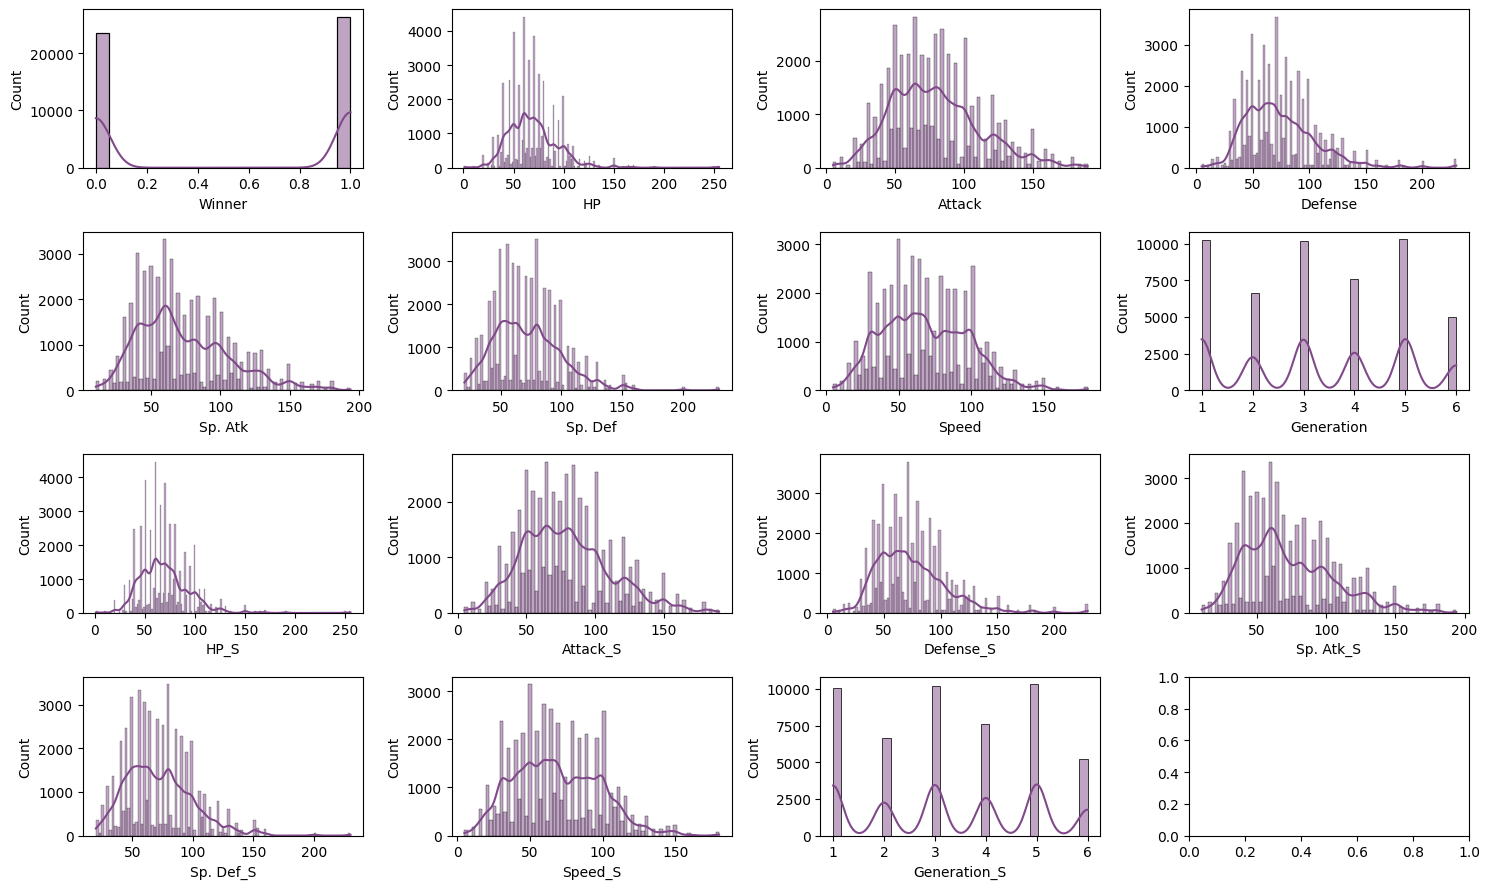

In [159]:
# Estraiamo i dati numerici dal dataframe
numeric_cols: list[str] = df_combats.select_dtypes(include=['int64', 'float64']).columns.tolist()

fig, axes = plt.subplots(4, 4, figsize=(15, 9))
for idx, col in enumerate(numeric_cols):
    ax = axes.flat[idx]
    sb.histplot(df_combats[col], kde=True, ax=ax, color=bar_color)
plt.tight_layout()

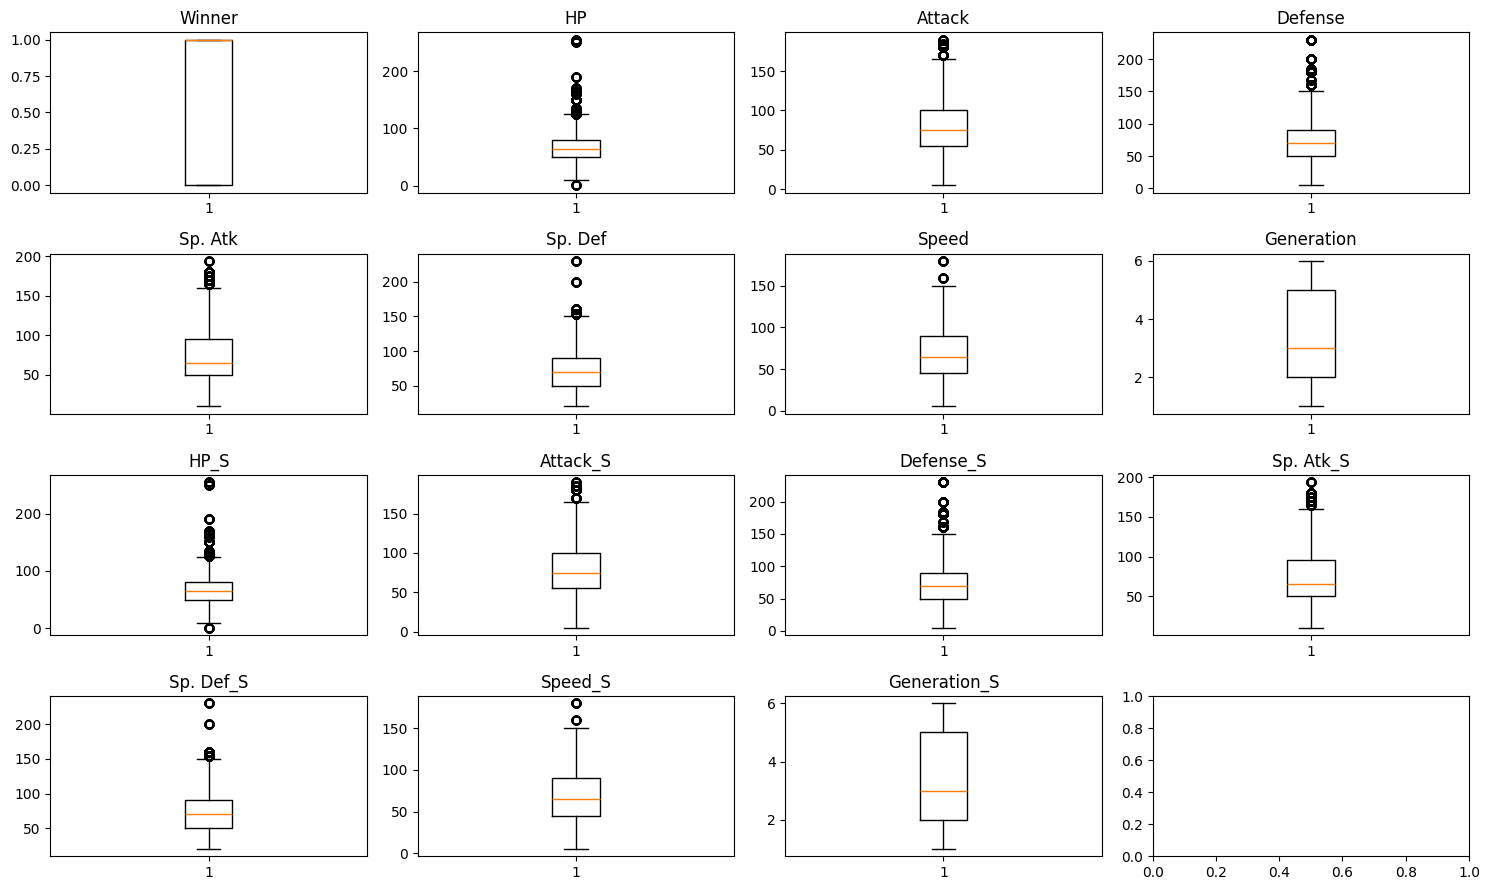

In [160]:
fig, axes = plt.subplots(4, 4, figsize=(15, 9))
for idx, col in enumerate(numeric_cols):
    ax = axes.flat[idx]
    ax.boxplot(df_combats[col])
    ax.set_title(col)
fig.tight_layout()

## Feature Engineering  <a id="feature-engineering"></a>

In [161]:
def get_dual_multiplier(df, atk_col, def1_col, def2_col, newcol):
   tmp = df_type_chart.rename(columns={
      'attack': atk_col,
      'defense1': def1_col,
      'defense2': def2_col
   })
   df = df.merge(
      tmp[[atk_col, def1_col, def2_col, 'multiplier']],
      on=[atk_col, def1_col, def2_col],
      how='left'
   ).rename(columns={'multiplier': newcol})
   df[newcol] = df[newcol].fillna(1.0)
   return df

df_combats_with_multiplier = df_combats.copy()
df_combats_with_multiplier = get_dual_multiplier(df_combats_with_multiplier, 'Type 1', 'Type 1_S', 'Type 2_S', 'F1_to_S')
df_combats_with_multiplier = get_dual_multiplier(df_combats_with_multiplier, 'Type 2', 'Type 1_S', 'Type 2_S', 'F2_to_S')
df_combats_with_multiplier = get_dual_multiplier(df_combats_with_multiplier, 'Type 1_S', 'Type 1', 'Type 2', 'S1_to_F')
df_combats_with_multiplier = get_dual_multiplier(df_combats_with_multiplier, 'Type 2_S', 'Type 1', 'Type 2', 'S2_to_F')
df_combats_with_multiplier.drop(columns=['Type 1', 'Type 2', 'Type 1_S', 'Type 2_S'], inplace=True)

In [162]:
# Rimpiazzo delle statistiche con la differenza delle statistiche tra i due pokemon
stats: list[str] = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for stat in stats:
   df_combats_with_multiplier[f"delta_{stat}"] = df_combats_with_multiplier[f'{stat}'] - df_combats_with_multiplier[f'{stat}_S']
   df_combats_with_multiplier.drop(columns=[f'{stat}', f'{stat}_S'], inplace=True)

In [163]:
# Rimozione delle colonne non necessarie
df_combats_with_multiplier.drop(columns=['Name', 'Name_S', 'Generation', 'Generation_S'], inplace=True)

## Analisi delle Correlazioni <a id="analisi-delle-correlazioni"></a>

<Axes: >

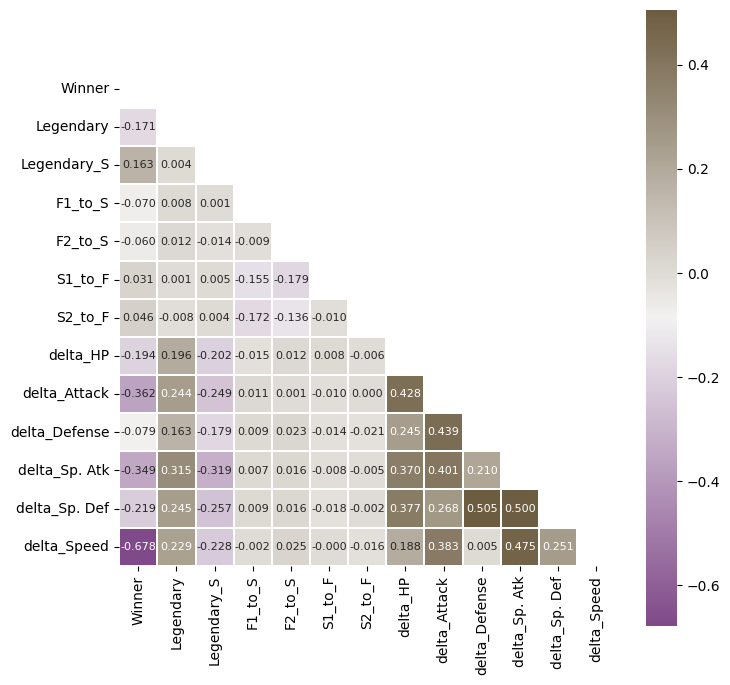

In [164]:
numerical_dataset_correlation: pd.DataFrame = df_combats_with_multiplier.corr()
# Create an upper triangular mask to avoid displaying the same data twice
mask: np.ndarray = np.zeros_like(numerical_dataset_correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Plot the correlation between the variables
plt.figure(figsize=(8, 8))
sb.heatmap(numerical_dataset_correlation, mask=mask, annot=True, square=True, linewidths=0.1, cmap=cmap, fmt=".3f", annot_kws={"fontsize":8})

# Addestramento e Tuning dei Modelli <a id="addestramento-e-tuning-dei-modelli"></a>

In [165]:
# Funzione per addestrare i modelli e calcolare il punteggio
def train_and_score(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    return accuracy_score(y_test, preds)

# Creazione del dataset di addestramento e test
y = df_combats_with_multiplier['Winner']
X = df_combats_with_multiplier.drop(columns=['Winner'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [166]:
# Codifica delle variabili categoriche
# Otteniamo le label delle variabili categoriche
labels_categoriche: list[str] = ['Legendary', 'Legendary_S']
# Preprocessing delle variabili categoriche e numeriche
processed_numerical_columns: list[str] = X.select_dtypes(include=np.number).columns.tolist();
column_encoder: ColumnTransformer = ColumnTransformer(
    transformers=[
    ("numeric", StandardScaler(), processed_numerical_columns),
    ("categorical", OneHotEncoder(drop='first', sparse_output=False), labels_categoriche),
], sparse_threshold=0.0)

In [171]:
# Modello dummy
dummy_model: Pipeline = Pipeline([
    ('preprocessor', column_encoder),
    ('classifier', DummyClassifier(strategy='uniform', random_state=RANDOM_STATE))
])

In [168]:
# Modello lineare
linear_model: Pipeline = Pipeline([
    ('column_encoder', column_encoder),
    ('logistic_l1', LogisticRegression(penalty='l1', solver='liblinear'))
])

In [169]:
# Modello decision tree
decision_tree_model: Pipeline = Pipeline([
    ('column_encoder', column_encoder),
    ("tree", RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
])

In [170]:
# Modello xgboost
xgboost_model: Pipeline = Pipeline([
   ('column_encoder', column_encoder),
   ("xgboost", XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE))
])

In [146]:
# Creazione di una griglia di ricerca per ottimizzare i parametri del modello XGBoost
param_grid: dict = {
   'n_estimators': [200, 300, 400],
   'max_depth': [8, 9, 10],
   'learning_rate': [0.05, 0.1, 0.15]
}
grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE), param_grid, cv=3, scoring='r2')
grid_xgb.fit(X_train, y_train)
print(f"Best parameters: {grid_xgb.best_params_}")
# Modello xgboost
xgboost_grid_model: Pipeline = Pipeline([
   ('column_encoder', column_encoder),
   ("xgboost", grid_xgb.best_estimator_)
])

Best parameters: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 400}


In [172]:
# Addestramento e valutazione dei modelli creati
models: list = [dummy_model, linear_model, decision_tree_model, xgboost_model, xgboost_grid_model]
model_names: list = ['Dummy', 'Logistic Regression', 'Decision Tree', 'XGBoost', 'XGBoost with Grid Search']
# Visualizzazione dei risultati dei modelli
for model, name in zip(models, model_names):
   score: float = train_and_score(model, X_train, y_train, X_test, y_test)
   print(f"{name} score: {score:.4f}")

Dummy score: 0.5084
Logistic Regression score: 0.8824
Decision Tree score: 0.9631
XGBoost score: 0.9641
XGBoost with Grid Search score: 0.9645


In [173]:
# Salvataggio dei modelli
if not os.path.exists('models'):
   os.makedirs('models')

for model, name in zip(models, model_names):
   print(f"Saving model: {name}")
   joblib.dump(model, f'models/{name.replace(" ", "_").lower()}.joblib')

Saving model: Dummy
Saving model: Logistic Regression
Saving model: Decision Tree
Saving model: XGBoost
Saving model: XGBoost with Grid Search


# Valutazione dei Modelli <a id="valutazione-dei-modelli"></a>